# Flight Delays: Part 2 - Modeling
*Author: Robert Harrow* | *Flatiron School Capstone Project*

In the previous notebook we downloaded all the data, dealt with missing values. We also engineered some features that might be useful for modeling purposes, like airport congestion. Now that we have all that prepared, we're ready to work on developing a model that detects severe flight delays.

## Business Understanding

Our task at hand is to help a hypothetical startup, Flight Chicken, build a model for detecting severe flight delays. We define 'severe delays' as those that result in a flight arriving more than 60 minutes late to its destination. Such delays are more likely to cause massive disruptions to travelers -- such as causing them to miss a connecting flight.

A model that predicts flight delays can empower its users to make appropriate changes to their travel plans so that a delay is less disruptive and sudden.

### Our Success Metric

We are looking for a model that achieves the best **F1 score**, without letting accuracy fall below 70%.

**Why F1?** F1 scores are a balance between Precision and Recall. It's important for a startup like Flight Chicken to build consumer trust. That's why it's important for it to detect and not miss predicting a delay. On its own, that means we would want to use Recall. However, if we optimize a model for Recall, it may have a lower Precision. In other words, it may too aggressively guess that something is a delay. But in doing so, it would unnecessarily worry Flight Chicken's users about a flight that will be on time. F1 is the harmonic average between Precision and Recall which is why it's our primary success metric for this project.

#### F1 Formula
$$ F1 = {2 * Precision x Recall \over Precision + Recall} $$

#### Precision Formula
$$ Precision = {True Positives \over Predicted Positives} $$

#### Recall Formula
$$ Recall = {True Positivies \over Actual Total Positives} $$

## Importing Libraries

First, we import some libraries to help us out throughout this notebook.

In [1]:
# Standard libraries for working with data
import pandas as pd
import glob
import os
import numpy as np
import random

# Libraries for processing and manipulating data for modeling
from sklearn.model_selection import train_test_split
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, OneHotEncoder

# Libraries for evaluating models
from sklearn.metrics import accuracy_score, precision_score, recall_score,\
f1_score, ConfusionMatrixDisplay, classification_report

# Libraries for plotting results
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

# Importing classifier algorithms
from sklearn.dummy import DummyClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from sklearn.ensemble import RandomForestClassifier

# Importing libraries for calculating class & sample weights to deal with imbalanced data
from sklearn.utils.class_weight import compute_class_weight
from sklearn.utils.class_weight import compute_sample_weight
from collections import Counter

# Import pickle to save our model so that we can use it on our remote server
import pickle

# Supress warning messages
import warnings
warnings.filterwarnings(action='ignore', category=FutureWarning)

### Importing Prepared Data

First we bring in the data that was cleaned and prepared in our previous notebook.

In [2]:
# Importing data
carrier_data = pd.read_csv('data/prepared/data_for_modeling.csv')

As a refresher, let's inspect the data to see what it looks like.

In [3]:
# Get information on the dataframe and its features
carrier_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5404853 entries, 0 to 5404852
Data columns (total 36 columns):
 #   Column                       Dtype  
---  ------                       -----  
 0   MONTH                        int64  
 1   DAY_OF_MONTH                 int64  
 2   DAY_OF_WEEK                  object 
 3   MKT_CARRIER                  object 
 4   ORIGIN                       object 
 5   DEST                         object 
 6   CRS_ELAPSED_TIME             float64
 7   DISTANCE                     float64
 8   target                       object 
 9   origin-elevation             float64
 10  dest-elevation               float64
 11  takeoff-time-of-day          object 
 12  arrival-time-of-day          object 
 13  ARR_DAY_OF_WEEK              object 
 14  avg-takeoff-congestion       float64
 15  avg-arrival-congestion       float64
 16  dest-avg-takeoff-congestion  float64
 17  dest-avg-arrival-congestion  float64
 18  holiday                      object 
 19  

In [4]:
# Now let's preview the first 5 rows
pd.set_option('display.max_columns', 36)
carrier_data.head()

,MONTH,DAY_OF_MONTH,DAY_OF_WEEK,MKT_CARRIER,ORIGIN,DEST,CRS_ELAPSED_TIME,DISTANCE,target,origin-elevation,dest-elevation,takeoff-time-of-day,arrival-time-of-day,ARR_DAY_OF_WEEK,avg-takeoff-congestion,avg-arrival-congestion,dest-avg-takeoff-congestion,dest-avg-arrival-congestion,holiday,days-from-specific-holiday,takeoff-mins-from-midnight,landing-mins-from-midnight,maxtemp,mintemp,avgtemp,totalprecip,avgvis,maxwind,avghumidity,dest-maxtemp,dest-mintemp,dest-avgtemp,dest-totalprecip,dest-avgvis,dest-maxwind,dest-avghumidity
0,6,1,Tuesday,DL,LAS,MSP,186.0,1299.0,No,2181.0,841.0,Night,Early Morning,Tuesday,1.329932,1.209226,1.776888,1.384968,Not a Holiday,Memorial Day_1.0,15,321,37.7,22.2,32.3,0.0,10.0,10.8,14.0,24.7,13.4,20.3,0.0,10.0,9.7,53.0
1,6,1,Tuesday,DL,LAS,MSP,183.0,1299.0,No,2181.0,841.0,Early Morning,Late Morning,Tuesday,2.024347,1.501475,1.644992,1.296566,Not a Holiday,Memorial Day_1.0,370,673,37.7,22.2,32.3,0.0,10.0,10.8,14.0,24.7,13.4,20.3,0.0,10.0,9.7,53.0
2,6,1,Tuesday,DL,LAS,MSP,183.0,1299.0,No,2181.0,841.0,Late Morning,Early Afternoon,Tuesday,1.683796,1.420449,1.689478,1.362348,Not a Holiday,Memorial Day_1.0,554,857,37.7,22.2,32.3,0.0,10.0,10.8,14.0,24.7,13.4,20.3,0.0,10.0,9.7,53.0
3,6,1,Tuesday,WN,LAS,MSP,185.0,1299.0,No,2181.0,841.0,Late Morning,Early Afternoon,Tuesday,1.683796,1.420449,1.689478,1.362348,Not a Holiday,Memorial Day_1.0,630,935,37.7,22.2,32.3,0.0,10.0,10.8,14.0,24.7,13.4,20.3,0.0,10.0,9.7,53.0
4,6,1,Tuesday,DL,LAS,MSP,188.0,1299.0,No,2181.0,841.0,Late Morning,Late Afternoon,Tuesday,1.683796,1.420449,1.254342,1.400000,Not a Holiday,Memorial Day_1.0,701,1009,37.7,22.2,32.3,0.0,10.0,10.8,14.0,24.7,13.4,20.3,0.0,10.0,9.7,53.0


We already explored what these features are in our previous notebook.

However, one important note here is that we will treat MONTH and DAY_OF_MONTH (currently ints) as objects because they are not truly continuous variables. There are just 12 months and between 28 and 30 days depending on the month. So let's transform those.

In [5]:
carrier_data['MONTH'] = carrier_data['MONTH'].astype(str)
carrier_data['DAY_OF_MONTH'] = carrier_data['DAY_OF_MONTH'].astype(str)

### Samping Down Data

We have 4,342,575 total flight records. That is too much to model with (at least on the machine we are running locally). We'll save out a sample of this data to use in modeling. We can always test later on whether including more data helps the models.

In [6]:
# Sample 5% of our data which will still result in over 100,000 records
carrier_data_sample = carrier_data.sample(frac=0.05, axis=0, random_state=123)
carrier_data_sample.to_csv('data/prepared/data_for_modeling_sample.csv', index=False)

#### Plotting Target Distribution
Our data is heavily skewed. Just 7% of all flight records qualify under our definition of 'severe delay'.

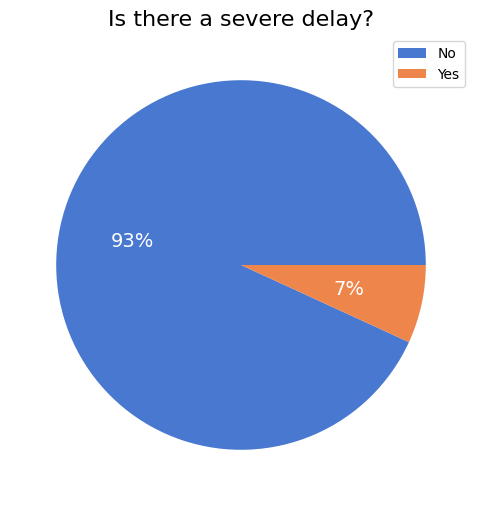

In [7]:
distribution = carrier_data['target'].value_counts(normalize=True)
# Plotting
colors = sns.color_palette('muted')[0:2]
distribution.plot.pie(figsize=(11, 6),
                      autopct='%1.0f%%',
                      colors = colors,
                      ylabel='',
                      textprops={'fontsize': 14, 'color':"w"})
plt.title("Is there a severe delay?", fontsize=16)
plt.legend()
plt.show()

We'll account for this in our modeling by setting sample and class weights.

### Splitting up data for training, validation & testing
To model data, we need to have it split into training, test and validation sets. We will iterate over our models using the training and validation data. Once we're ready to settle on a final model, we can evaluate it using previously unseen test data.

In [8]:
# Splitting features & target
y = carrier_data_sample["target"]
X = carrier_data_sample.drop(["target"], axis=1)

# Creating train, test and validation sets
X_train, X_rem, y_train, y_rem = train_test_split(X,y, train_size=0.8)

test_size = 0.5
X_valid, X_test, y_valid, y_test = train_test_split(X_rem,y_rem, test_size=0.5)

Before modeling, we will need to carry out transformations on the data. To do this, we need to separate numeric and categorical features since those will require different treatment.

In [9]:
num_cols = ['CRS_ELAPSED_TIME', 'DISTANCE', 'origin-elevation', 'dest-elevation',
            'avg-takeoff-congestion', 'avg-arrival-congestion', 'dest-avg-takeoff-congestion',
            'dest-avg-arrival-congestion', 'takeoff-mins-from-midnight', 'landing-mins-from-midnight',
            'maxtemp', 'mintemp', 'avgtemp', 'totalprecip', 'avgvis', 'maxwind', 'avghumidity',
            'dest-maxtemp', 'dest-mintemp', 'dest-avgtemp', 'dest-totalprecip', 'dest-avgvis',
            'dest-maxwind', 'dest-avghumidity']

cat_cols = ['MONTH', 'DAY_OF_MONTH', 'DAY_OF_WEEK', 'MKT_CARRIER', 'ORIGIN',
            'DEST', 'takeoff-time-of-day', 'arrival-time-of-day', 'ARR_DAY_OF_WEEK',
            'holiday', 'days-from-specific-holiday']

To transform data for modeling, we'll be making use of pipelines to simplify things.

In [10]:
# We create a column transformer that has two parts
# The first transform acts on our cat_cols and OneHotEncodes those columns
# The second transform applies a StandardScaler on our numeric columns
col_transform = ColumnTransformer(transformers=[('categorical', OneHotEncoder(categories="auto",
                                                                      sparse=False,
                                                                      handle_unknown="ignore"), cat_cols),
                                                ('numeric', StandardScaler(), num_cols)])

Our data is also highly imbalanced with the target (severe delay) only happing 7% of the time. To deal with this class imbalance, we'll compute some sample weights which we can later test in some of the models we iterate through.

In [11]:
# We use compute_class_weight from sklearn to calculate the weights
class_weights = compute_class_weight(class_weight = "balanced",
                                     classes = np.unique(y_train),
                                     y = y_train)

# Then we add these weights into a dictionary
class_weights_dict = dict(zip(np.unique(y_train), class_weights))

# Finally, we also calculate sample weights which can be used with XGBoost Classifiers
sample_weights = compute_sample_weight(class_weight='balanced', y=y_train)

### Modeling
We'll be working with different Gradient Descent models because they are good at handling classification tasks. There are a number of classifiers we'll throw at our problem including Logistic Regression, Random Forests, XGBoost and LightGBM.

#### Helper Function

We create a function to evaluate model performance. This will help keep track of how each model iteration does in relation to our success metric. It will also help us spot overfitting.

In [12]:
def evaluate_model(pipe, X, y_true):
    """
    This function takes a modeling pipeline, a dataframe (x), and true labels (y)
    The function returns a confusion matrix, an accuracy score, precision, recall and F1
    """
    y_pred  = pipe.predict(X) # generate a set of predictions
   
    print('Evaluation Scores:')
    print('--------------')
    accuracy = accuracy_score(y_true, y_pred)
    print('Accuracy: %.3f' % round(accuracy, 3))
    # precision tp / (tp + fp)
    precision = precision_score(y_true, y_pred, pos_label='Yes')
    print('Precision: %.3f' % round(precision, 3))
    # recall: tp / (tp + fn)
    recall = recall_score(y_true, y_pred, pos_label='Yes')
    print('Recall: %.3f' % round(recall, 3))
    # f1: 2 tp / (2 tp + fp + fn)
    f1 = f1_score(y_true, y_pred, pos_label='Yes')
    print('F1 score: %.3f' % round(f1, 3))
    print('--------------')
    print('Confusion Matrix:')

    ConfusionMatrixDisplay.from_predictions(y_true, y_pred, normalize='true')
    plt.show()
    
    # Print a classification report
    print('Classification Report:')
    print(classification_report(y_true, y_pred))

### Dummy Baseline Model

We start off by building a simple model that will serve as a benchmark. This model simply guesses the dominant class (no delay) every time.

Evaluation Scores:
--------------
Accuracy: 0.931


C:\Users\rharr\anaconda3\envs\flight-app-dev\lib\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Precision: 0.000
Recall: 0.000
F1 score: 0.000
--------------
Confusion Matrix:


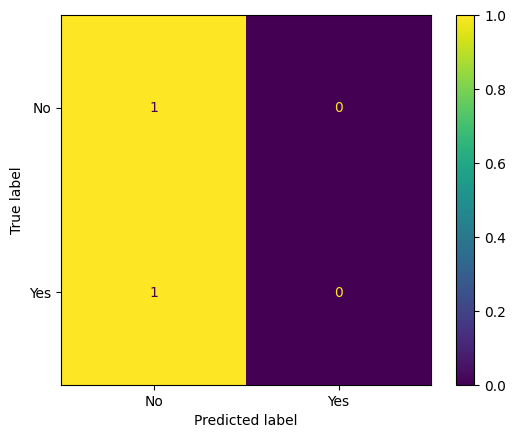

Classification Report:


C:\Users\rharr\anaconda3\envs\flight-app-dev\lib\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\rharr\anaconda3\envs\flight-app-dev\lib\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


              precision    recall  f1-score   support

          No       0.93      1.00      0.96    201350
         Yes       0.00      0.00      0.00     14844

    accuracy                           0.93    216194
   macro avg       0.47      0.50      0.48    216194
weighted avg       0.87      0.93      0.90    216194



C:\Users\rharr\anaconda3\envs\flight-app-dev\lib\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [13]:
baselline_pipe = Pipeline(steps=[('prep', col_transform),
                                 ('dc', DummyClassifier(strategy='most_frequent'))])

baselline_pipe.fit(X_train, y_train)

evaluate_model(baselline_pipe, X_train, y_train)

### Logistic Regression
Our first real model is logistic regression. We'll always start off by running our models with default parameters and tweak our hyperparameters afterwards to see if we can get better performance.

C:\Users\rharr\anaconda3\envs\flight-app-dev\lib\site-packages\sklearn\linear_model\_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Training Scores:
Evaluation Scores:
--------------
Accuracy: 0.931
Precision: 0.654
Recall: 0.001
F1 score: 0.002
--------------
Confusion Matrix:


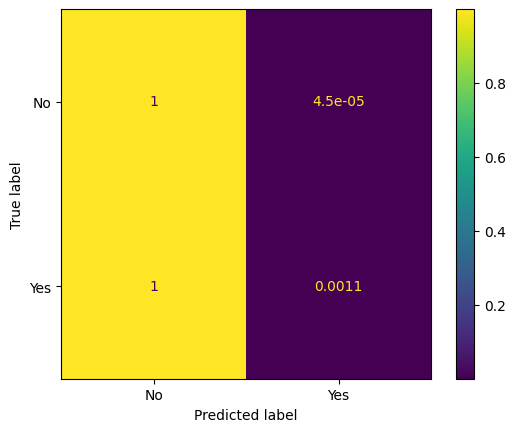

Classification Report:
              precision    recall  f1-score   support

          No       0.93      1.00      0.96    201350
         Yes       0.65      0.00      0.00     14844

    accuracy                           0.93    216194
   macro avg       0.79      0.50      0.48    216194
weighted avg       0.91      0.93      0.90    216194



In [14]:
# Defining our logistic regression pipe
lr_pipe1 = Pipeline(steps=[('prep', col_transform), # Column transformations we defined in an earlier step
                           ('lr', LogisticRegression(random_state=123))]) # The model itself

# We fit the model on our training data
lr_pipe1.fit(X_train, y_train)

# And now we score the model
print('Training Scores:')
evaluate_model(lr_pipe1, X_train, y_train)

Validation Scores:
Evaluation Scores:
--------------
Accuracy: 0.932
Precision: 0.500
Recall: 0.001
F1 score: 0.001
--------------
Confusion Matrix:


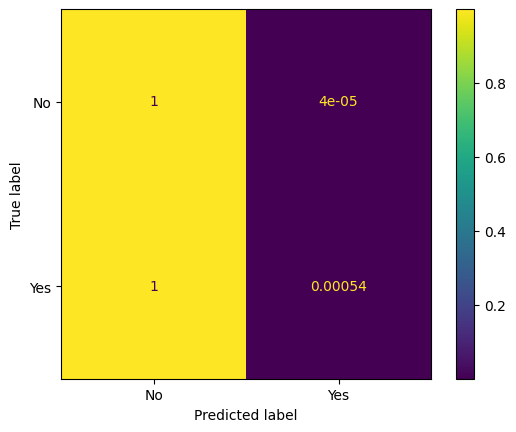

Classification Report:
              precision    recall  f1-score   support

          No       0.93      1.00      0.96     25178
         Yes       0.50      0.00      0.00      1846

    accuracy                           0.93     27024
   macro avg       0.72      0.50      0.48     27024
weighted avg       0.90      0.93      0.90     27024



In [15]:
print('Validation Scores:')
evaluate_model(lr_pipe1, X_valid, y_valid)

This model is just barely better than our dummy classifier. It's simply always guessing the dominant class (no delay). It's highly conservative. Next we try passing class weights into the model to see how that improves it.

C:\Users\rharr\anaconda3\envs\flight-app-dev\lib\site-packages\sklearn\linear_model\_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Evaluation Scores:
--------------
Accuracy: 0.649
Precision: 0.122
Recall: 0.667
F1 score: 0.207
--------------
Confusion Matrix:


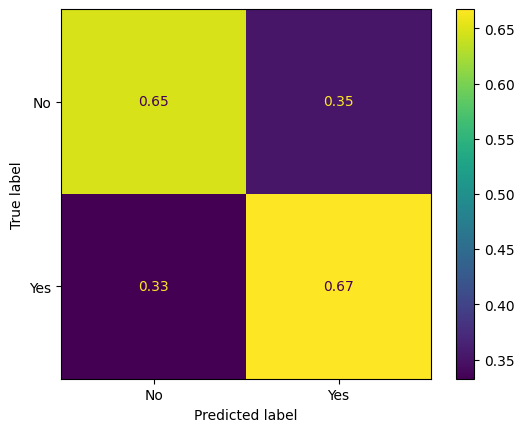

Classification Report:
              precision    recall  f1-score   support

          No       0.96      0.65      0.77    201350
         Yes       0.12      0.67      0.21     14844

    accuracy                           0.65    216194
   macro avg       0.54      0.66      0.49    216194
weighted avg       0.91      0.65      0.74    216194



In [16]:
# We create a new pipe with class weights
lr_pipe2 = Pipeline(steps=[('prep', col_transform),
                           ('lr', LogisticRegression(class_weight=class_weights_dict, random_state=123))])

# Fit & evaluate
lr_pipe2.fit(X_train, y_train)
evaluate_model(lr_pipe2, X_train, y_train)

Evaluation Scores:
--------------
Accuracy: 0.641
Precision: 0.120
Recall: 0.671
F1 score: 0.203
--------------
Confusion Matrix:


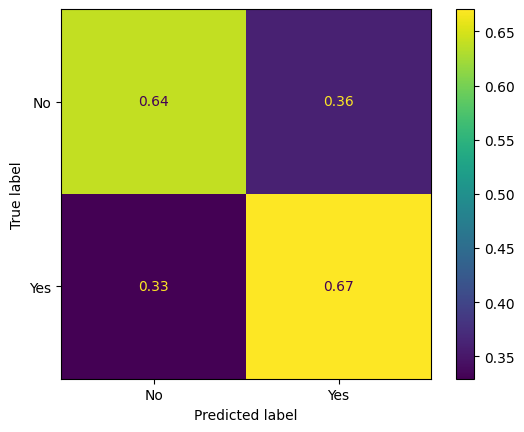

Classification Report:
              precision    recall  f1-score   support

          No       0.96      0.64      0.77     25178
         Yes       0.12      0.67      0.20      1846

    accuracy                           0.64     27024
   macro avg       0.54      0.65      0.49     27024
weighted avg       0.91      0.64      0.73     27024



In [17]:
# Checking model on validation data
evaluate_model(lr_pipe2, X_valid, y_valid)

**Much** better. This was a big jump in performance. Our F1 score jumped up to 0.2. The accuracy is somewhat poor (65%). On fitting, the model also failed to converge before hitting the iteration limit. We'll try increasing the max allowed iterations from 100 to 1,000 and see if that delivers better performance. Of course, doing this we risk introducing overfitting.

Evaluation Scores:
--------------
Accuracy: 0.650
Precision: 0.123
Recall: 0.667
F1 score: 0.207
--------------
Confusion Matrix:


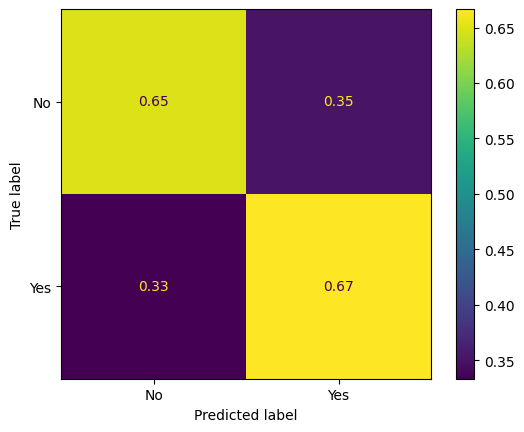

Classification Report:
              precision    recall  f1-score   support

          No       0.96      0.65      0.78    201350
         Yes       0.12      0.67      0.21     14844

    accuracy                           0.65    216194
   macro avg       0.54      0.66      0.49    216194
weighted avg       0.91      0.65      0.74    216194



In [18]:
lr_pipe3 = Pipeline(steps=[('prep', col_transform),
                           ('lr', LogisticRegression(class_weight=class_weights_dict,
                                                     max_iter=1000,
                                                     random_state=123))])

lr_pipe3.fit(X_train, y_train)

evaluate_model(lr_pipe3, X_train, y_train)

Evaluation Scores:
--------------
Accuracy: 0.642
Precision: 0.120
Recall: 0.673
F1 score: 0.204
--------------
Confusion Matrix:


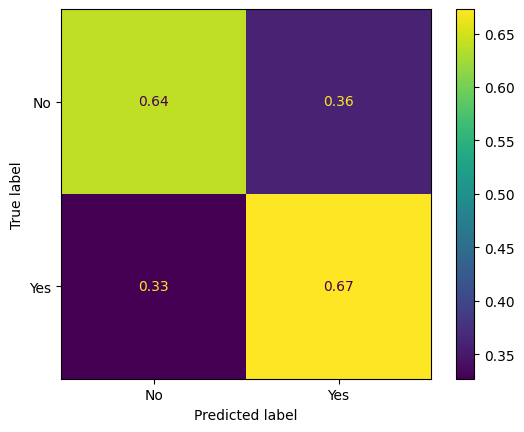

Classification Report:
              precision    recall  f1-score   support

          No       0.96      0.64      0.77     25178
         Yes       0.12      0.67      0.20      1846

    accuracy                           0.64     27024
   macro avg       0.54      0.66      0.49     27024
weighted avg       0.91      0.64      0.73     27024



In [19]:
# Checking model on validation data
evaluate_model(lr_pipe3, X_valid, y_valid)

The model didn't start overfitting, but we also didn't see much of an improvement to accuracy (64.8% vs 64.7% before). Our F1 score also stayed the same.

We'll try another classifier altogether next.

### Random Forest
Random Forest classifiers are another classic option for classification tasks. They work by fitting a number of decision tree classifiers on sub-samples of our data and average over them to improve accuracy.

Evaluation Scores:
--------------
Accuracy: 0.931


C:\Users\rharr\anaconda3\envs\flight-app-dev\lib\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Precision: 0.000
Recall: 0.000
F1 score: 0.000
--------------
Confusion Matrix:


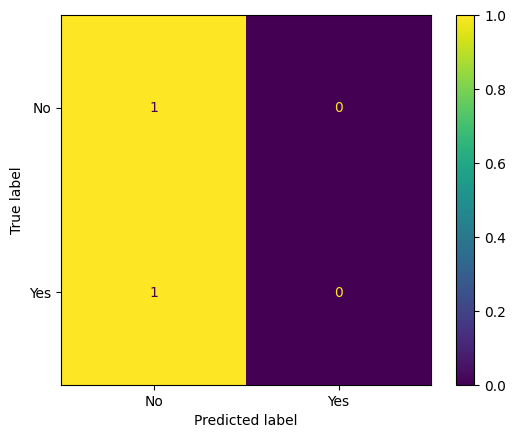

Classification Report:


C:\Users\rharr\anaconda3\envs\flight-app-dev\lib\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\rharr\anaconda3\envs\flight-app-dev\lib\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


              precision    recall  f1-score   support

          No       0.93      1.00      0.96    201350
         Yes       0.00      0.00      0.00     14844

    accuracy                           0.93    216194
   macro avg       0.47      0.50      0.48    216194
weighted avg       0.87      0.93      0.90    216194



C:\Users\rharr\anaconda3\envs\flight-app-dev\lib\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [20]:
rf_pipe = Pipeline(steps=[('prep', col_transform),
                           ('rf', RandomForestClassifier(n_estimators=100,
                                  max_depth=12,
                                  random_state=123))])
rf_pipe.fit(X_train, y_train)

evaluate_model(rf_pipe, X_train, y_train)

Evaluation Scores:
--------------
Accuracy: 0.932
Precision: 0.000


C:\Users\rharr\anaconda3\envs\flight-app-dev\lib\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Recall: 0.000
F1 score: 0.000
--------------
Confusion Matrix:


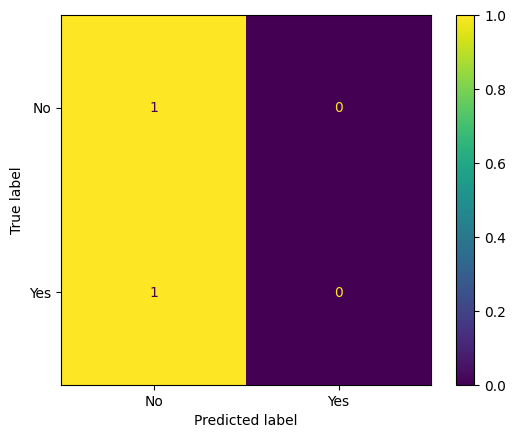

Classification Report:


C:\Users\rharr\anaconda3\envs\flight-app-dev\lib\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


              precision    recall  f1-score   support

          No       0.93      1.00      0.96     25178
         Yes       0.00      0.00      0.00      1846

    accuracy                           0.93     27024
   macro avg       0.47      0.50      0.48     27024
weighted avg       0.87      0.93      0.90     27024



C:\Users\rharr\anaconda3\envs\flight-app-dev\lib\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\rharr\anaconda3\envs\flight-app-dev\lib\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [21]:
# Checking model on validation data
evaluate_model(rf_pipe, X_valid, y_valid)

Like with Logistic Regression, when we don't introduce class weights the model simply guesses there will be no delay which is useless for our problem. Moving forward, we will only try models that deal with class imbalance.

Evaluation Scores:
--------------
Accuracy: 1.000
Precision: 1.000
Recall: 0.999
F1 score: 1.000
--------------
Confusion Matrix:


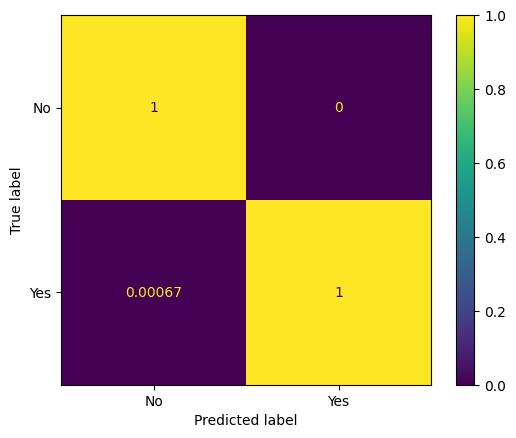

Classification Report:
              precision    recall  f1-score   support

          No       1.00      1.00      1.00    201350
         Yes       1.00      1.00      1.00     14844

    accuracy                           1.00    216194
   macro avg       1.00      1.00      1.00    216194
weighted avg       1.00      1.00      1.00    216194



In [22]:
# Now we call on a Random Forest classifier with default parameters, except for class_weights
rf_pipe_2 = Pipeline(steps=[('prep', col_transform),
                           ('rf', RandomForestClassifier(class_weight=class_weights_dict, random_state=123))])

# Fit and evaluate
rf_pipe_2.fit(X_train, y_train)
evaluate_model(rf_pipe_2, X_train, y_train)

Evaluation Scores:
--------------
Accuracy: 0.932
Precision: 0.500
Recall: 0.004
F1 score: 0.008
--------------
Confusion Matrix:


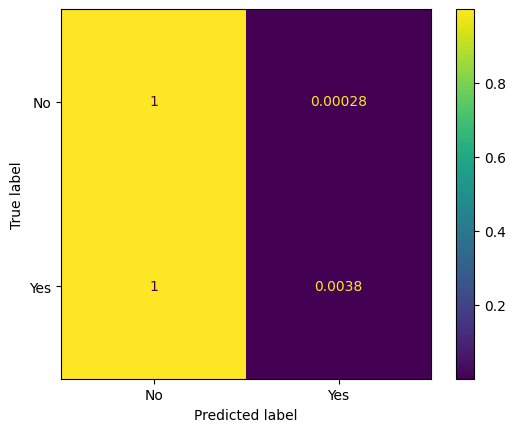

Classification Report:
              precision    recall  f1-score   support

          No       0.93      1.00      0.96     25178
         Yes       0.50      0.00      0.01      1846

    accuracy                           0.93     27024
   macro avg       0.72      0.50      0.49     27024
weighted avg       0.90      0.93      0.90     27024



In [23]:
# Checking model on validation data
evaluate_model(rf_pipe_2, X_valid, y_valid)

Something strange happened with this iteration. The training model always guessed that there was a severe delay, and it did the oppose on the validation data. I don't trust these results because of that strange behavior and keep moving on.

Evaluation Scores:
--------------
Accuracy: 0.637
Precision: 0.115
Recall: 0.644
F1 score: 0.196
--------------
Confusion Matrix:


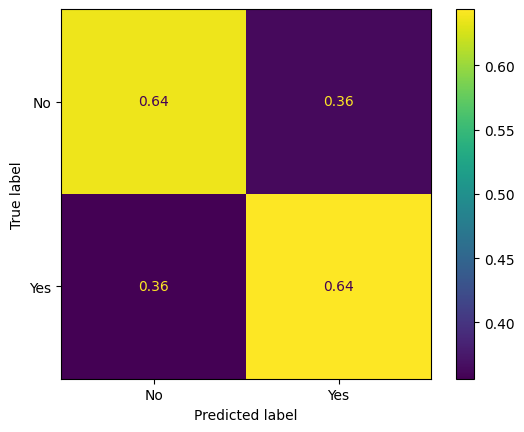

Classification Report:
              precision    recall  f1-score   support

          No       0.96      0.64      0.77    201350
         Yes       0.12      0.64      0.20     14844

    accuracy                           0.64    216194
   macro avg       0.54      0.64      0.48    216194
weighted avg       0.90      0.64      0.73    216194



In [24]:
rf_pipe3 = Pipeline(steps=[('prep', col_transform),
                           ('rf', RandomForestClassifier(n_estimators=100,
                                  max_depth=6,
                                  class_weight=class_weights_dict,
                                  random_state=123))])
rf_pipe3.fit(X_train, y_train)

evaluate_model(rf_pipe3, X_train, y_train)

Evaluation Scores:
--------------
Accuracy: 0.631
Precision: 0.112
Recall: 0.635
F1 score: 0.190
--------------
Confusion Matrix:


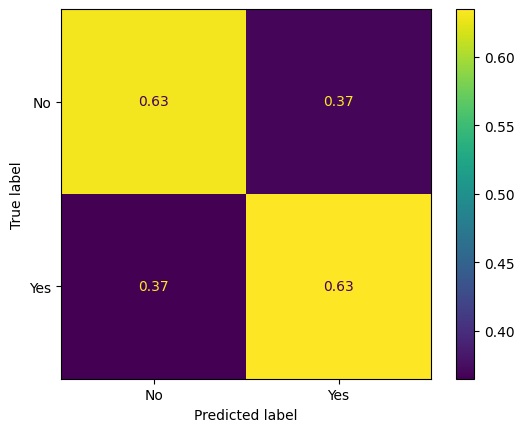

Classification Report:
              precision    recall  f1-score   support

          No       0.96      0.63      0.76     25178
         Yes       0.11      0.63      0.19      1846

    accuracy                           0.63     27024
   macro avg       0.54      0.63      0.48     27024
weighted avg       0.90      0.63      0.72     27024



In [25]:
evaluate_model(rf_pipe3, X_valid, y_valid)

The overfitting improved. However, now the F1 score dropped below what we had with the Logistic Regression model.

It looks like our Random Forest models can drive better performance, but are prone to overfitting. We'll try working with another classifier, XGBoost, to see if it does better.

### XGBoost
Is a popular classifier which has been the choice for many classification competitions on Kaggle. XGBoost is fast and outperforms many other supervised learning algorithms. The library is parallelizable which means it can be more efficient at handling larger training sets. We'll use that to our advantage and try to train a model on larger data samples.

But first, like before, we'll just start by running it with default parameters (apart from ones dealing with the class imbalance).

Evaluation Scores:
--------------
Accuracy: 0.677
Precision: 0.128
Recall: 0.641
F1 score: 0.214
--------------
Confusion Matrix:


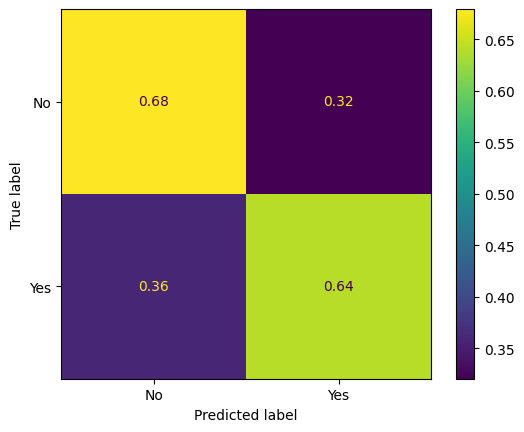

Classification Report:
              precision    recall  f1-score   support

          No       0.96      0.68      0.80    201350
         Yes       0.13      0.64      0.21     14844

    accuracy                           0.68    216194
   macro avg       0.55      0.66      0.51    216194
weighted avg       0.91      0.68      0.76    216194



In [27]:
# We initialize the pipe
xgb_pipe = Pipeline(steps=[('prep', col_transform),
                           ('xgb', XGBClassifier())])

# Here we fit the model and pass sample_weight parameters to the model to deal with the class imbalance
xgb_pipe.fit(X_train, y_train, xgb__sample_weight=sample_weights)
evaluate_model(xgb_pipe, X_train, y_train)

Evaluation Scores:
--------------
Accuracy: 0.670
Precision: 0.124
Recall: 0.629
F1 score: 0.207
--------------
Confusion Matrix:


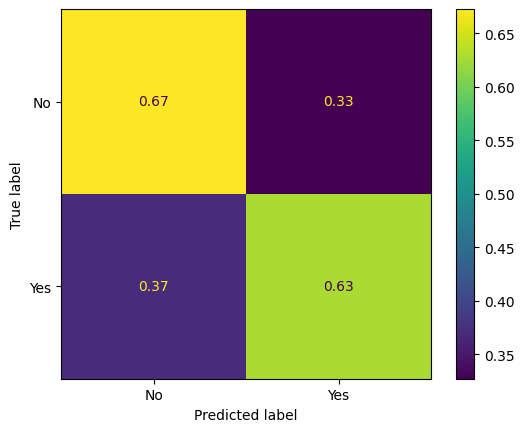

Classification Report:
              precision    recall  f1-score   support

          No       0.96      0.67      0.79     25178
         Yes       0.12      0.63      0.21      1846

    accuracy                           0.67     27024
   macro avg       0.54      0.65      0.50     27024
weighted avg       0.90      0.67      0.75     27024



In [28]:
# Checking model on validation data
evaluate_model(xgb_pipe, X_valid, y_valid)

The training set was our best one so far, but it's clearly overfitting given the differences between training and validation scores. We'll adjust some hyperparameters to try and combat the overfitting. We'll set our model to take a subsample of 0.4 of training data and set a max depth of 5.

Evaluation Scores:
--------------
Accuracy: 0.702
Precision: 0.142
Recall: 0.661
F1 score: 0.233
--------------
Confusion Matrix:


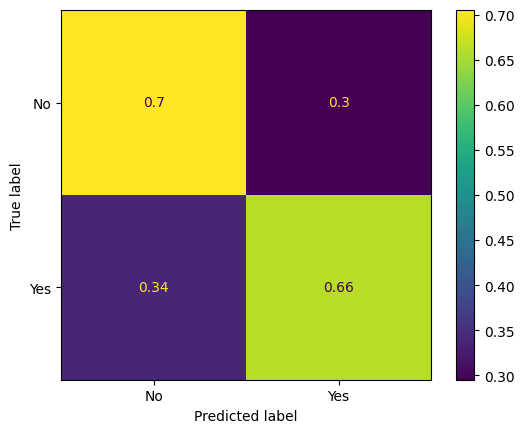

Classification Report:
              precision    recall  f1-score   support

          No       0.97      0.70      0.81    201350
         Yes       0.14      0.66      0.23     14844

    accuracy                           0.70    216194
   macro avg       0.55      0.68      0.52    216194
weighted avg       0.91      0.70      0.78    216194



In [29]:
xgb_pipe2 = Pipeline(steps=[('prep', col_transform),
                           ('xgb', XGBClassifier(subsample=0.4, max_depth=5, alpha = 100))])

xgb_pipe2.fit(X_train, y_train, xgb__sample_weight=sample_weights)
evaluate_model(xgb_pipe2, X_train, y_train)

Evaluation Scores:
--------------
Accuracy: 0.690
Precision: 0.128
Recall: 0.610
F1 score: 0.212
--------------
Confusion Matrix:


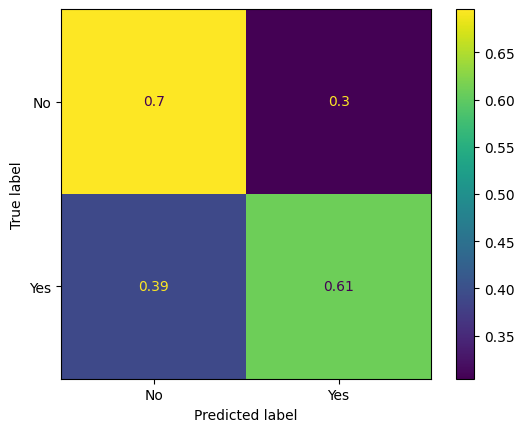

Classification Report:
              precision    recall  f1-score   support

          No       0.96      0.70      0.81     25178
         Yes       0.13      0.61      0.21      1846

    accuracy                           0.69     27024
   macro avg       0.54      0.65      0.51     27024
weighted avg       0.90      0.69      0.77     27024



In [30]:
# Checking model on validation data
evaluate_model(xgb_pipe2, X_valid, y_valid)

The overfitting got a little better and our performance is still good. This model is our best so far given the F1 score and accuracy.

XGBoost has one more way of dealing with imbalanced data sets -- and that's using scale_pos_weight. We'll try that to see if it changes our results. The recommendation is to set it to the negative case divided by the positive cases.

In [31]:
counter = Counter(y_train)
estimate = counter['No'] / counter['Yes']

Evaluation Scores:
--------------
Accuracy: 0.677
Precision: 0.129
Recall: 0.642
F1 score: 0.214
--------------
Confusion Matrix:


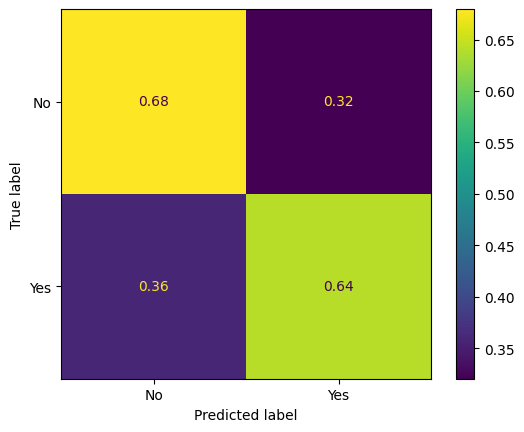

Classification Report:
              precision    recall  f1-score   support

          No       0.96      0.68      0.80    201350
         Yes       0.13      0.64      0.21     14844

    accuracy                           0.68    216194
   macro avg       0.55      0.66      0.51    216194
weighted avg       0.91      0.68      0.76    216194



In [32]:
xgb_pipe3 = Pipeline(steps=[('prep', col_transform),
                           ('xgb', XGBClassifier(scale_pos_weight=estimate))])

xgb_pipe3.fit(X_train, y_train)

evaluate_model(xgb_pipe3, X_train, y_train)

Evaluation Scores:
--------------
Accuracy: 0.671
Precision: 0.124
Recall: 0.626
F1 score: 0.207
--------------
Confusion Matrix:


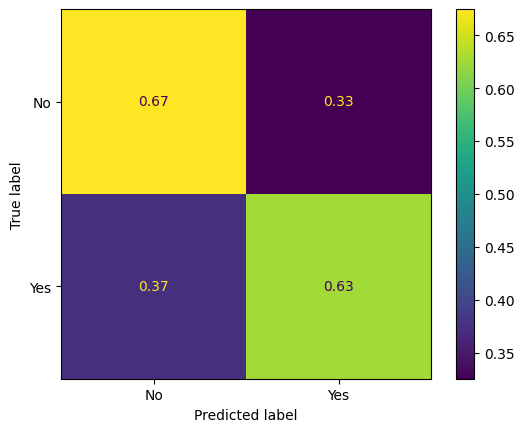

Classification Report:
              precision    recall  f1-score   support

          No       0.96      0.67      0.79     25178
         Yes       0.12      0.63      0.21      1846

    accuracy                           0.67     27024
   macro avg       0.54      0.65      0.50     27024
weighted avg       0.90      0.67      0.75     27024



In [33]:
# Checking model on validation data
evaluate_model(xgb_pipe3, X_valid, y_valid)

Our best performance so far! But still some overfitting. We again deal with that by reducing the sample of features down to 0.7.

Evaluation Scores:
--------------
Accuracy: 0.707
Precision: 0.146
Recall: 0.670
F1 score: 0.239
--------------
Confusion Matrix:


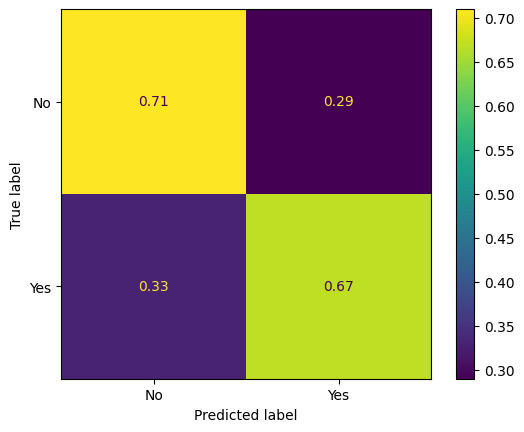

Classification Report:
              precision    recall  f1-score   support

          No       0.97      0.71      0.82    201350
         Yes       0.15      0.67      0.24     14844

    accuracy                           0.71    216194
   macro avg       0.56      0.69      0.53    216194
weighted avg       0.91      0.71      0.78    216194



In [34]:
xgb_pipe4 = Pipeline(steps=[('prep', col_transform),
                           ('xgb', XGBClassifier(scale_pos_weight=estimate,
                                  max_depth = 5,
                                  eta = 0.3,
                                  colsample_bytree = 0.7))])

xgb_pipe4.fit(X_train, y_train)
evaluate_model(xgb_pipe4, X_train, y_train)

Evaluation Scores:
--------------
Accuracy: 0.695
Precision: 0.131
Recall: 0.618
F1 score: 0.217
--------------
Confusion Matrix:


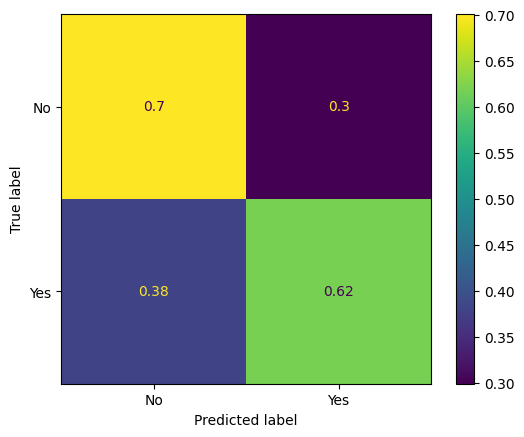

Classification Report:
              precision    recall  f1-score   support

          No       0.96      0.70      0.81     25178
         Yes       0.13      0.62      0.22      1846

    accuracy                           0.70     27024
   macro avg       0.55      0.66      0.51     27024
weighted avg       0.90      0.70      0.77     27024



In [35]:
# Checking model on validation data
evaluate_model(xgb_pipe4, X_valid, y_valid)

There is still a lot of overfitting here unfortunately. 

#### Increasing Training Sample Size
As stated previously, XGBoost is a fast algorithm. Because of that, we'll try to introduce more data into our training and see if that boosts performance and helps reduce overfitting.

In [36]:
# First we take a bigger sample of our data. Before we took 5%, so now we'll double it to 10%
bigger_sample = carrier_data.sample(frac=0.1, axis=0, random_state=123)

# We split our target and features like before
y_2 = bigger_sample["target"]
X_2 = bigger_sample.drop(["target"], axis=1)

# And now we split our data into training, test and validation sets like we did before
X_train_2, X_rem_2, y_train_2, y_rem_2 = train_test_split(X_2,y_2, train_size=0.8)
test_size = 0.5
X_valid_2, X_test_2, y_valid_2, y_test_2 = train_test_split(X_rem_2,y_rem_2, test_size=0.5)

Now we train an XGBoost model on the bigger sample. We increase our max_depth here as well. Hoping that the bigger sample will combat any overfitting that may introduce.

Evaluation Scores:
--------------
Accuracy: 0.752
Precision: 0.177
Recall: 0.711
F1 score: 0.283
--------------
Confusion Matrix:


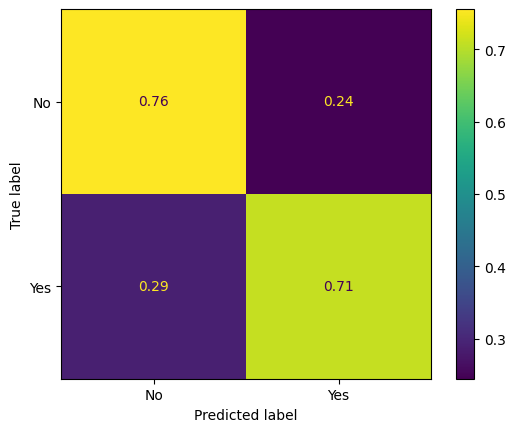

Classification Report:
              precision    recall  f1-score   support

          No       0.97      0.76      0.85    402599
         Yes       0.18      0.71      0.28     29789

    accuracy                           0.75    432388
   macro avg       0.57      0.73      0.57    432388
weighted avg       0.92      0.75      0.81    432388



In [37]:
xgb_pipe5 = Pipeline(steps=[('prep', col_transform),
                           ('xgb', XGBClassifier(scale_pos_weight=estimate,
                                  max_depth = 8,
                                  eta = 0.3,
                                  colsample_bytree = 0.7))])

xgb_pipe5.fit(X_train_2, y_train_2)
evaluate_model(xgb_pipe5, X_train_2, y_train_2)

Evaluation Scores:
--------------
Accuracy: 0.734
Precision: 0.145
Recall: 0.583
F1 score: 0.232
--------------
Confusion Matrix:


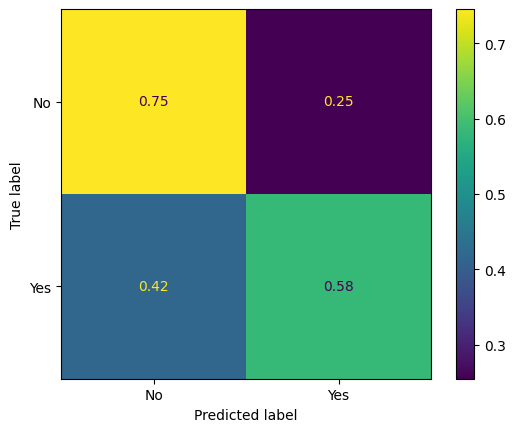

Classification Report:
              precision    recall  f1-score   support

          No       0.96      0.75      0.84     50325
         Yes       0.14      0.58      0.23      3723

    accuracy                           0.73     54048
   macro avg       0.55      0.66      0.54     54048
weighted avg       0.90      0.73      0.80     54048



In [38]:
# Checking model on validation data
evaluate_model(xgb_pipe5, X_valid_2, y_valid_2)

This is the best model so far! Though it's clearly still overfitting.

We'll try dealing with that with another sample size increase.

In [39]:
# First we take a bigger sample of our data. Before we took 10%, so now we'll double it to 20%
biggest_sample = carrier_data.sample(frac=0.2, axis=0, random_state=123)

# We split our target and features like before
y_3 = biggest_sample["target"]
X_3 = biggest_sample.drop(["target"], axis=1)

# And now we split our data into training, test and validation sets like we did before
X_train_3, X_rem_3, y_train_3, y_rem_3 = train_test_split(X_3,y_3, train_size=0.8)
test_size = 0.5
X_valid_3, X_test_3, y_valid_3, y_test_3 = train_test_split(X_rem_3,y_rem_3, test_size=0.5)

And now we fit the new sample.

Evaluation Scores:
--------------
Accuracy: 0.708
Precision: 0.143
Recall: 0.654
F1 score: 0.235
--------------
Confusion Matrix:


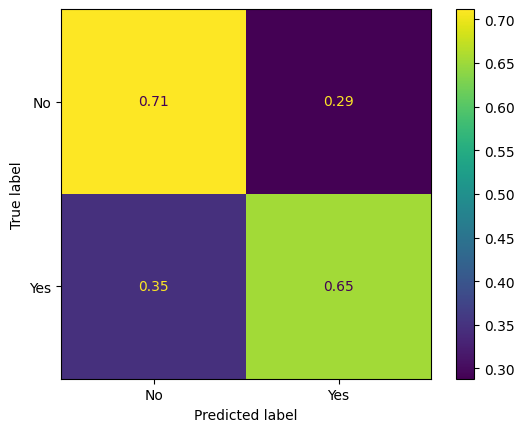

Classification Report:
              precision    recall  f1-score   support

          No       0.97      0.71      0.82    805441
         Yes       0.14      0.65      0.23     59335

    accuracy                           0.71    864776
   macro avg       0.55      0.68      0.53    864776
weighted avg       0.91      0.71      0.78    864776



In [40]:
xgb_pipe6 = Pipeline(steps=[('prep', col_transform),
                           ('xgb', XGBClassifier(scale_pos_weight=estimate,
                                  max_depth = 6,
                                  eta = 0.3,
                                  colsample_bytree = 0.7))])

xgb_pipe6.fit(X_train_3, y_train_3)
evaluate_model(xgb_pipe6, X_train_3, y_train_3)

Evaluation Scores:
--------------
Accuracy: 0.704
Precision: 0.139
Recall: 0.630
F1 score: 0.227
--------------
Confusion Matrix:


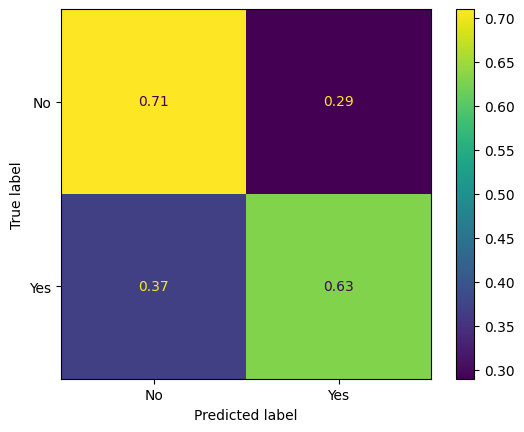

Classification Report:
              precision    recall  f1-score   support

          No       0.96      0.71      0.82    100642
         Yes       0.14      0.63      0.23      7455

    accuracy                           0.70    108097
   macro avg       0.55      0.67      0.52    108097
weighted avg       0.91      0.70      0.78    108097



In [41]:
# Checking model on validation data
evaluate_model(xgb_pipe6, X_valid_3, y_valid_3)

This is the best model performance we've seen so far and the overfitting got better, we'll try one more iteration of this model with some additional hyperparameters that might help with overfitting.

Evaluation Scores:
--------------
Accuracy: 0.705
Precision: 0.142
Recall: 0.654
F1 score: 0.233
--------------
Confusion Matrix:


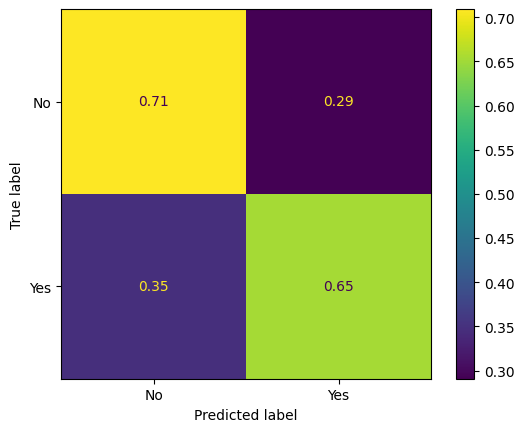

Classification Report:
              precision    recall  f1-score   support

          No       0.97      0.71      0.82    805441
         Yes       0.14      0.65      0.23     59335

    accuracy                           0.71    864776
   macro avg       0.55      0.68      0.53    864776
weighted avg       0.91      0.71      0.78    864776



In [42]:
xgb_pipe7 = Pipeline(steps=[('prep', col_transform),
                           ('xgb', XGBClassifier(scale_pos_weight=estimate,
                                  max_depth = 6,
                                  subsample=0.4,
                                  eta = 0.2,
                                  colsample_bytree = 0.8))])

xgb_pipe7.fit(X_train_3, y_train_3)
evaluate_model(xgb_pipe7, X_train_3, y_train_3)

Evaluation Scores:
--------------
Accuracy: 0.702
Precision: 0.138
Recall: 0.630
F1 score: 0.226
--------------
Confusion Matrix:


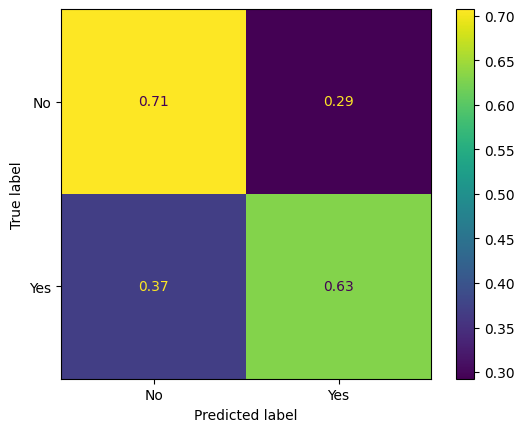

Classification Report:
              precision    recall  f1-score   support

          No       0.96      0.71      0.82    100642
         Yes       0.14      0.63      0.23      7455

    accuracy                           0.70    108097
   macro avg       0.55      0.67      0.52    108097
weighted avg       0.91      0.70      0.77    108097



In [43]:
# Checking model on validation data
evaluate_model(xgb_pipe7, X_valid_3, y_valid_3)

The overfitting got slightly better but our F1 score dropped. Given more time, it would be worth exploring expanding the data even more. But for now, given this satisfies our business problem we stop here.

### LightGBM

We've got one last classifier to try out - LightGBM. It's another highly popular algorithm that was developed by Microsoft. Like XGBoost, it is said LightGBM is fast for large data. So we'll increase our sample one last time.

In [44]:
# First we take a bigger sample of our data. Before we took 10%, so now we'll double it to 20%
biggest_sample_2 = carrier_data.sample(frac=0.4, axis=0, random_state=123)

# We split our target and features like before
y_4 = biggest_sample["target"]
X_4 = biggest_sample.drop(["target"], axis=1)

# And now we split our data into training, test and validation sets like we did before
X_train_4, X_rem_4, y_train_4, y_rem_4 = train_test_split(X_4,y_4, train_size=0.8)
test_size = 0.5
X_valid_4, X_test_4, y_valid_4, y_test_4 = train_test_split(X_rem_4,y_rem_4, test_size=0.5)

Evaluation Scores:
--------------
Accuracy: 0.695
Precision: 0.139
Recall: 0.663
F1 score: 0.230
--------------
Confusion Matrix:


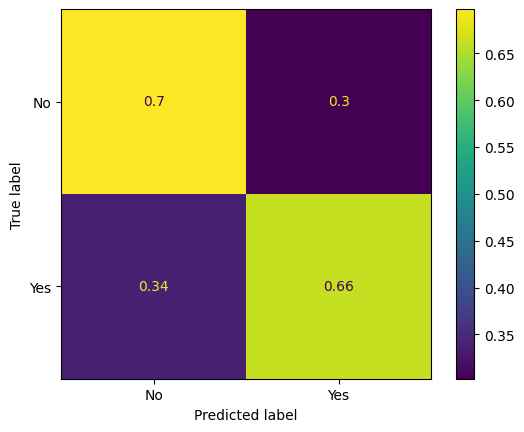

Classification Report:
              precision    recall  f1-score   support

          No       0.97      0.70      0.81    805404
         Yes       0.14      0.66      0.23     59372

    accuracy                           0.69    864776
   macro avg       0.55      0.68      0.52    864776
weighted avg       0.91      0.69      0.77    864776



In [45]:
lgbm_pipe1 = Pipeline(steps=[('prep', col_transform),
                           ('lgbm', LGBMClassifier(scale_pos_weight=estimate, max_depth = 12))])

lgbm_pipe1.fit(X_train_4, y_train_4)
evaluate_model(lgbm_pipe1, X_train_4, y_train_4)

Evaluation Scores:
--------------
Accuracy: 0.694
Precision: 0.136
Recall: 0.652
F1 score: 0.226
--------------
Confusion Matrix:


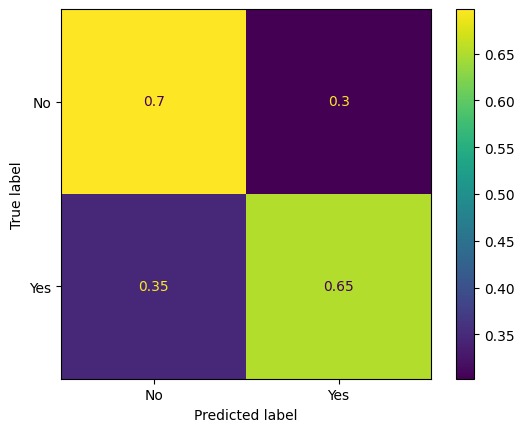

Classification Report:
              precision    recall  f1-score   support

          No       0.96      0.70      0.81    100708
         Yes       0.14      0.65      0.23      7389

    accuracy                           0.69    108097
   macro avg       0.55      0.67      0.52    108097
weighted avg       0.91      0.69      0.77    108097



In [46]:
evaluate_model(lgbm_pipe1, X_valid_4, y_valid_4)

Doubling the sample size lead to about the same F1 score we saw with the best XGB model but with slightly worse accuracy. We'll try using a class weight instead of the sample size estimate.

Evaluation Scores:
--------------
Accuracy: 0.700
Precision: 0.140
Recall: 0.657
F1 score: 0.231
--------------
Confusion Matrix:


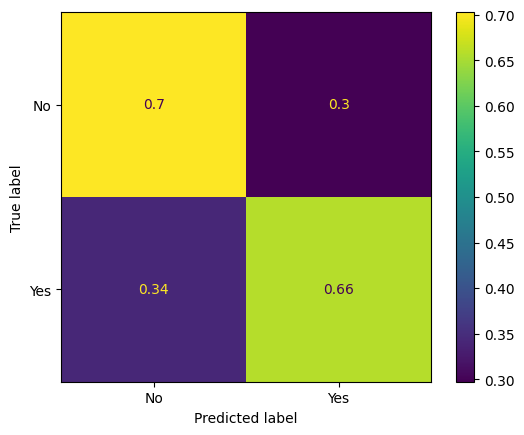

Classification Report:
              precision    recall  f1-score   support

          No       0.97      0.70      0.81    805404
         Yes       0.14      0.66      0.23     59372

    accuracy                           0.70    864776
   macro avg       0.55      0.68      0.52    864776
weighted avg       0.91      0.70      0.77    864776



In [47]:
lgbm_pipe2 = Pipeline(steps=[('prep', col_transform),
                           ('lgbm', LGBMClassifier(class_weight='balanced', max_depth = 12))])

lgbm_pipe2.fit(X_train_4, y_train_4)
evaluate_model(lgbm_pipe2, X_train_4, y_train_4)

Evaluation Scores:
--------------
Accuracy: 0.699
Precision: 0.137
Recall: 0.645
F1 score: 0.226
--------------
Confusion Matrix:


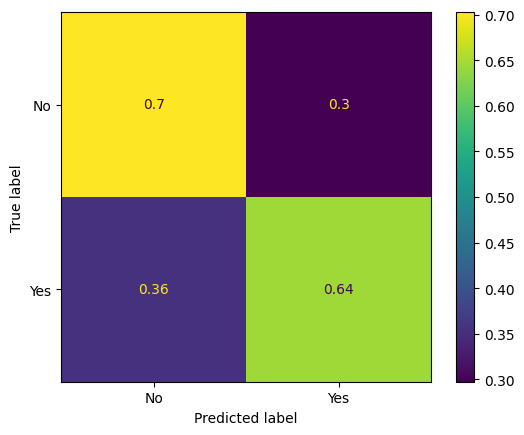

Classification Report:
              precision    recall  f1-score   support

          No       0.96      0.70      0.81    100708
         Yes       0.14      0.64      0.23      7389

    accuracy                           0.70    108097
   macro avg       0.55      0.67      0.52    108097
weighted avg       0.91      0.70      0.77    108097



In [48]:
evaluate_model(lgbm_pipe2, X_valid_4, y_valid_4)

The fitting is now taking a while and we're not seeing improvements to the models so we'll stop here.

## Evaluating final model on test data

Our 6th XGBoost model had the best F1 score and accuracy so we select it as our final model. Let's see how it does on unseen test data.

Evaluation Scores:
--------------
Accuracy: 0.703
Precision: 0.136
Recall: 0.623
F1 score: 0.224
--------------
Confusion Matrix:


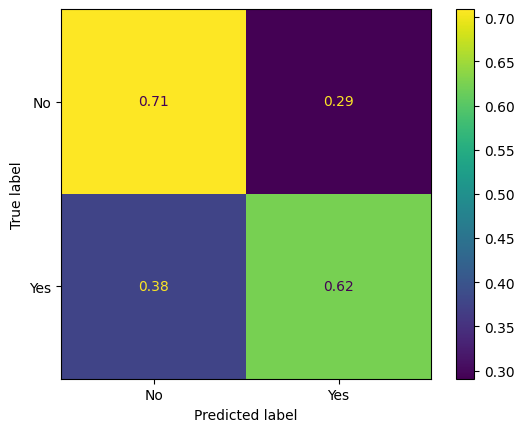

Classification Report:
              precision    recall  f1-score   support

          No       0.96      0.71      0.82    100693
         Yes       0.14      0.62      0.22      7405

    accuracy                           0.70    108098
   macro avg       0.55      0.67      0.52    108098
weighted avg       0.91      0.70      0.78    108098



In [49]:
evaluate_model(xgb_pipe6, X_test_3, y_test_3)

Great! The F1 score on our test data is close to what it was on our training and validation sets. We'll move forward and save out this model.

In [50]:
# Saving best performing model
path = 'app/model.sav'
pickle.dump(xgb_pipe6, open(path, 'wb'))

#### Feature importances
Let's investigate which features were most helpful to our model.

In [51]:
# Grab numer feature names and put them into a list
numeric_features_list = list(num_cols)

# Grab the categorical feature names after OHE transform and put them into our list
onehot_columns = list(xgb_pipe6.named_steps['prep'].named_transformers_['categorical'].get_feature_names(input_features=cat_cols))
numeric_features_list.extend(onehot_columns)

# Extract feature weights into a list
feature_weights = list(xgb_pipe6.named_steps["xgb"].feature_importances_)

# Throw our features and weights into a dataframe
feature_importances = pd.DataFrame(
    {'Feature': numeric_features_list,
     'Weight': feature_weights
    })

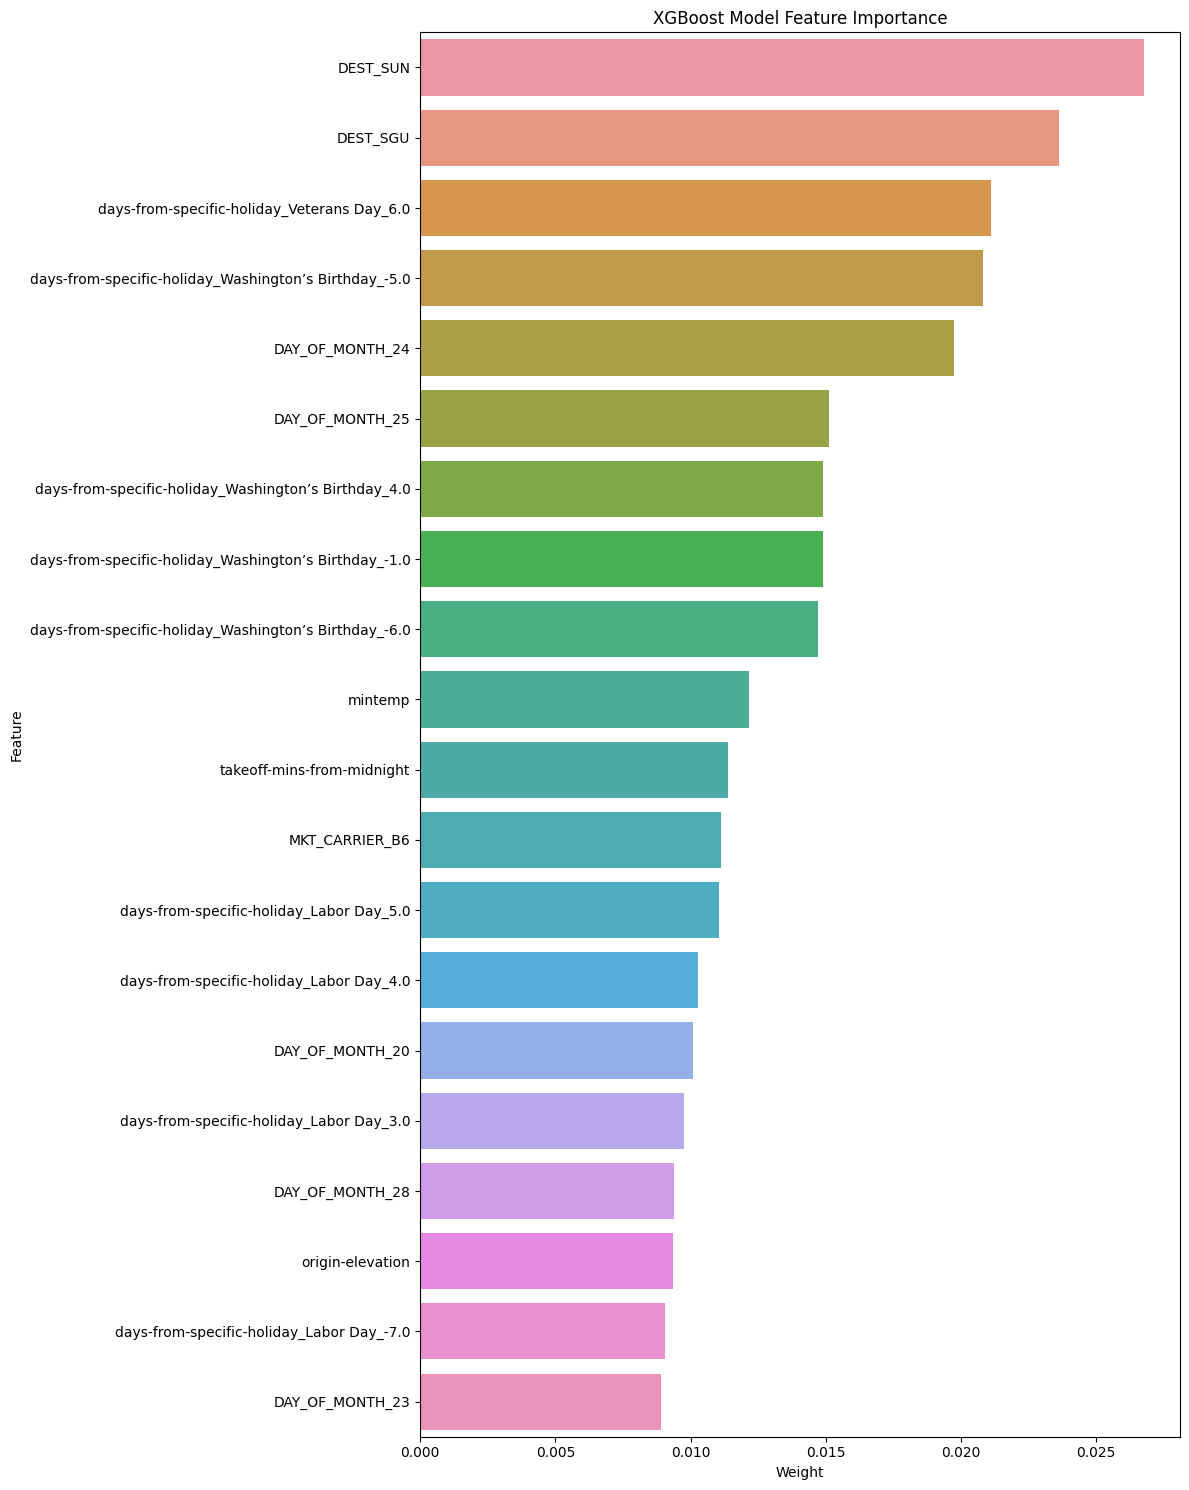

In [52]:
# Plotting feature importances
plt.figure(figsize=(12, 15))
sns.barplot(x="Weight", y="Feature", data=feature_importances.sort_values(by="Weight", ascending=False).head(20))
plt.title('XGBoost Model Feature Importance')
plt.tight_layout()
plt.show()

There are some interesting trends in our top 20 features. We can see proximity to holidays like Thanksgiving, Veterans Day, Labor Day and MLK day are overly represented as predictors. We also see congestion and weather showing up.

## Conclusions
We've reached a stopping point for the modeling portion of this project.

Given more time, future iterations of this product might include things like generating more samples with SMOTE, increasing the training sample size or trying different types of models (including Deep learning).

* We managed to build a model that achieved a 0.24 F1 score and 72% overall accuracy
* Our model is a custom XGBoost Classifier which successfully detects 62% of severe delays
* Proximity to holidays, precipitation and certain days of the year are among the strongest predictors
* The biggest gains in performance came from dealing with the severe class imbalance and increasing the sample size of the training data
* We'll next work to productionize this model using Flask and Dash and deploy it to a remote server
